# Part 6, Model 3 NN: Glaucoma Detection using a neural network on the fundus, the optic cup, and the optic disk images of the eye + calculated OC feature + calculated OD feature + computed I-GRI (Integrated Glaucoma Risk Index) feature (predictive imputation used to fill up NaN values) using statistical analysis.

In [1]:
%pip install scikit-learn
%pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf

from pathlib import Path

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

2024-03-31 15:10:30.904958: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 15:10:30.905048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 15:10:31.002904: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-31 15:10:31.175226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-31 15:10:32.785065: W tensorflow/compiler/tf2

In [3]:
tf.__version__

'2.15.0'

In [4]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

fundus_subset = pd.read_csv('metadata - standardized.csv')

In [5]:
fundus_subset.columns

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')

In [6]:
fundus_subset.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
fundus_subset['fundus_oc_seg'].dtype

dtype('O')

In [8]:
fundus_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [9]:
print(fundus_subset['fundus'][12044])
print(fundus_subset['fundus_oc_seg'][12044])
print(fundus_subset['fundus_od_seg'][12044])

/full-fundus/PAPILA-484.png
/optic-cup/PAPILA-484.png
/optic-disc/PAPILA-484.png


full-fundus/full-fundus/PAPILA-484.png


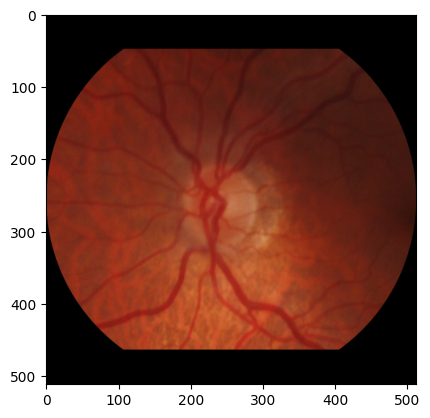

optic-cup/optic-cup/PAPILA-484.png


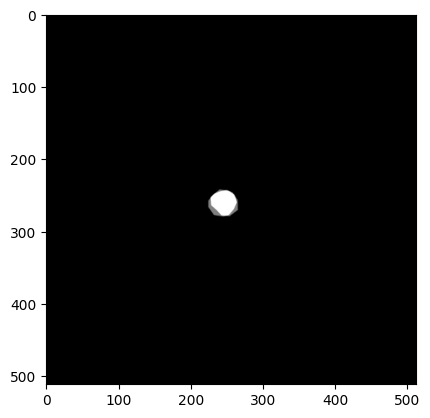

optic-disc/optic-disc/PAPILA-484.png


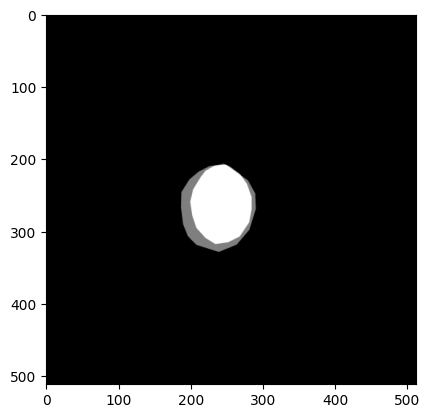

In [10]:
def viewFundus(image_path):

    image_path = 'full-fundus' + image_path

    print(image_path)

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('on')
    plt.show()

def viewOpticCup(image_path):

    image_path = 'optic-cup' + image_path

    print(image_path)

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('on')
    plt.show()

def viewOpticDisc(image_path):

    image_path = 'optic-disc' + image_path

    print(image_path)

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('on')
    plt.show()


viewFundus(fundus_subset['fundus'][12044])
viewOpticCup(fundus_subset['fundus_oc_seg'][12044])
viewOpticDisc(fundus_subset['fundus_od_seg'][12044])

In [11]:
fundus_subset.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
fundus_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [13]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

fundus_subset = fundus_subset.dropna(axis=1, how='all')

fundus_subset['eye'] = fundus_subset['eye'].replace({'OD': 0, 'OS': 1})

for col in ['gender', 'eye']:
    if col in fundus_subset.columns:
        mode = fundus_subset[col].mode()[0]
        fundus_subset[col] = fundus_subset[col].fillna(mode)

numerical_data = fundus_subset.select_dtypes(include=[np.number])

rf_regressor = RandomForestRegressor(
    n_estimators=150,
    max_features='sqrt',
    n_jobs=-1,
    random_state=None
)

imp = IterativeImputer(
    estimator=rf_regressor,
    max_iter=10,
    random_state=None
)

numerical_data_imputed = imp.fit_transform(numerical_data)

numerical_data_imputed = pd.DataFrame(numerical_data_imputed, columns=numerical_data.columns, index=numerical_data.index)

integer_columns = ['types', 'isColor', 'gender', 'eye', 'age']
for col in integer_columns:
    if col in numerical_data_imputed.columns:
        numerical_data_imputed[col] = numerical_data_imputed[col].round().astype('Int64')

non_numerical_data = fundus_subset.select_dtypes(exclude=[np.number])
data_imputed = pd.concat([numerical_data_imputed, non_numerical_data], axis=1)

data_imputed = data_imputed.loc[fundus_subset.index]

print("Shape of imputed data:", data_imputed.shape)

Shape of imputed data: (12449, 47)


/root/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [14]:
print(data_imputed.describe())

          types  isColor    gender        age       eye           sbp  \
count   12449.0  12449.0   12449.0    12449.0   12449.0  12449.000000   
mean   0.372239      1.0  0.985059  56.787613   0.77444    193.122588   
std    0.505039      0.0  0.121322  10.237948  0.417968     76.838819   
min        -1.0      1.0       0.0        1.0       0.0    107.000000   
25%         0.0      1.0       1.0       45.0       1.0    129.640000   
50%         0.0      1.0       1.0       62.0       1.0    143.646667   
75%         1.0      1.0       1.0       62.0       1.0    301.280000   
max         1.0      1.0       1.0       91.0       1.0    412.000000   

                dbp            hr           iop          vcdr  ...  \
count  12449.000000  12449.000000  12449.000000  12449.000000  ...   
mean      77.809184     65.641755     13.285834      0.550788  ...   
std        8.481651      3.544548      1.407832      0.118637  ...   
min       47.000000     51.000000      8.000000      0.161000 

In [20]:
data_imputed[["eye"]].value_counts()

eye
1      9641
0      2808
Name: count, dtype: int64

In [21]:
fundus_subset = fundus_subset[fundus_subset['fundus_oc_seg'] != 'Not Visible']

In [26]:
fundus_subset = data_imputed

fundus_subset

,types,isColor,gender,age,eye,sbp,dbp,hr,iop,vcdr,...,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect,OC size
0,0,1,1,58,0,137.326667,84.913333,68.133333,13.380000,0.568367,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,1,60,1,131.500000,84.113333,67.913333,13.173333,0.585985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,1,66,1,145.666667,87.740000,69.460000,15.453333,0.610706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,1,70,0,177.240000,86.560000,71.760000,16.493333,0.619178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1,1,45,1,299.513333,82.613333,65.206667,12.660000,0.457129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12444,0,1,1,45,1,301.280000,82.926667,66.220000,12.760000,0.344096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
12445,0,1,1,45,1,301.280000,82.926667,66.220000,12.760000,0.344096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
12446,0,1,1,45,1,301.280000,82.926667,66.220000,12.760000,0.344096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
12447,0,1,1,45,1,301.280000,82.926667,66.220000,12.760000,0.344096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


optic-cup/optic-cup/PAPILA-484.png
optic-cup/optic-cup/PAPILA-484.png


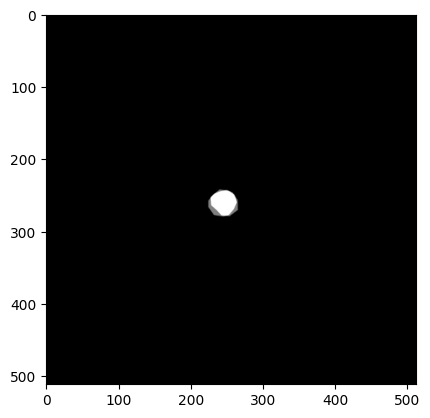

Normalized OC Area: 0.004856109619140625


In [27]:
import cv2
import numpy as np

def compute_normalized_area_optic_cup(masked_image_path):

    try:

        masked_image_path = 'optic-cup' + masked_image_path

        print(masked_image_path)

        masked_image = cv2.imread(masked_image_path)
        
        gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

        _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

        white_area = np.sum(binary_mask == 255)

        total_pixels = masked_image.shape[0] * masked_image.shape[1]
        
        normalized_area = white_area / total_pixels

        return normalized_area
    
    except Exception as e:
        
        print(f"Skipping: Error processing image at {masked_image_path}: {e}")
        return None

normalized_area = compute_normalized_area_optic_cup(fundus_subset['fundus_oc_seg'][12044])

viewOpticCup(fundus_subset['fundus_oc_seg'][12044])

print(f"Normalized OC Area: {normalized_area}")

optic-disc/optic-disc/PAPILA-484.png
optic-disc/optic-disc/PAPILA-484.png


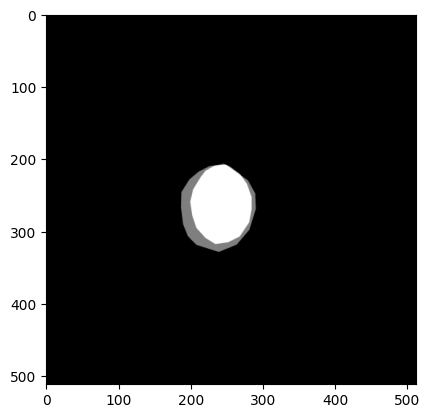

Normalized OD Area: 0.037567138671875


In [28]:
import cv2
import numpy as np

def compute_normalized_area_optic_disc(masked_image_path):

    try:

        masked_image_path = 'optic-disc' + masked_image_path

        print(masked_image_path)

        masked_image = cv2.imread(masked_image_path)
        
        gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

        _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

        white_area = np.sum(binary_mask == 255)

        total_pixels = masked_image.shape[0] * masked_image.shape[1]
        
        normalized_area = white_area / total_pixels

        return normalized_area
    
    except Exception as e:
        
        print(f"Skipping: Error processing image at {masked_image_path}: {e}")
        return None

normalized_area = compute_normalized_area_optic_disc(fundus_subset['fundus_od_seg'][12044])

viewOpticDisc(fundus_subset['fundus_od_seg'][12044])

print(f"Normalized OD Area: {normalized_area}")

In [29]:
fundus_subset = fundus_subset [

    (fundus_subset['fundus'].notnull()) &
    (fundus_subset['fundus_oc_seg'].notnull()) & 
    (fundus_subset['fundus_od_seg'].notnull()) & (fundus_subset['types'] != -1)
]

fundus_subset = fundus_subset[['types', 'fundus', 'fundus_oc_seg', 'fundus_od_seg', 'names', 'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3034 entries, 4546 to 12048
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   types          3034 non-null   object 
 1   fundus         3034 non-null   object 
 2   fundus_oc_seg  3034 non-null   object 
 3   fundus_od_seg  3034 non-null   object 
 4   names          3034 non-null   object 
 5   gender         3034 non-null   Int64  
 6   age            3034 non-null   Int64  
 7   eye            3034 non-null   Int64  
 8   sbp            3034 non-null   float64
 9   dbp            3034 non-null   float64
 10  hr             3034 non-null   float64
 11  iop            3034 non-null   float64
 12  vcdr           3034 non-null   float64
 13  cdr_avg        3034 non-null   float64
 14  combined       3034 non-null   object 
dtypes: Int64(3), float64(6), object(6)
memory usage: 388.1+ KB


/tmp/ipykernel_396/4096321830.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['combined'] = fundus_subset['names'] + '.png'
/tmp/ipykernel_396/4096321830.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)
/tmp/ipykernel_396/4096321830.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [30]:
fundus_subset['types'].value_counts()

types
0    2310
1     724
Name: count, dtype: int64

In [31]:
fundus_subset = fundus_subset[fundus_subset['fundus_oc_seg'] != 'Not Visible']
fundus_subset = fundus_subset[fundus_subset['fundus_od_seg'] != 'Not Visible']
fundus_subset = fundus_subset[fundus_subset['fundus'] != 'Not Visible']

In [32]:
import cv2
import numpy as np
import pandas as pd

fundus_subset['OC size'] = 0.0

for index, row in fundus_subset.iterrows():
    normalized_area = compute_normalized_area_optic_cup(row['fundus_oc_seg'])
    fundus_subset.at[index, 'OC size'] = normalized_area

optic-cup/optic-cup/ORIGA-1.png
optic-cup/optic-cup/ORIGA-2.png
optic-cup/optic-cup/ORIGA-3.png
optic-cup/optic-cup/ORIGA-4.png
optic-cup/optic-cup/ORIGA-5.png
optic-cup/optic-cup/ORIGA-6.png
optic-cup/optic-cup/ORIGA-7.png
optic-cup/optic-cup/ORIGA-8.png
optic-cup/optic-cup/ORIGA-9.png
optic-cup/optic-cup/ORIGA-10.png
optic-cup/optic-cup/ORIGA-11.png
optic-cup/optic-cup/ORIGA-12.png
optic-cup/optic-cup/ORIGA-13.png
optic-cup/optic-cup/ORIGA-14.png
optic-cup/optic-cup/ORIGA-15.png
optic-cup/optic-cup/ORIGA-16.png
optic-cup/optic-cup/ORIGA-17.png
optic-cup/optic-cup/ORIGA-18.png
optic-cup/optic-cup/ORIGA-19.png
optic-cup/optic-cup/ORIGA-20.png
optic-cup/optic-cup/ORIGA-21.png
optic-cup/optic-cup/ORIGA-22.png
optic-cup/optic-cup/ORIGA-23.png
optic-cup/optic-cup/ORIGA-24.png
optic-cup/optic-cup/ORIGA-25.png
optic-cup/optic-cup/ORIGA-26.png
optic-cup/optic-cup/ORIGA-27.png
optic-cup/optic-cup/ORIGA-28.png
optic-cup/optic-cup/ORIGA-29.png
optic-cup/optic-cup/ORIGA-30.png
optic-cup/optic-cup

In [33]:
import cv2
import numpy as np
import pandas as pd

fundus_subset['OD size'] = 0.0  

for index, row in fundus_subset.iterrows():
    normalized_area = compute_normalized_area_optic_disc(row['fundus_od_seg'])
    fundus_subset.at[index, 'OD size'] = normalized_area

optic-disc/optic-disc/ORIGA-1.png
optic-disc/optic-disc/ORIGA-2.png
optic-disc/optic-disc/ORIGA-3.png
optic-disc/optic-disc/ORIGA-4.png
optic-disc/optic-disc/ORIGA-5.png
optic-disc/optic-disc/ORIGA-6.png
optic-disc/optic-disc/ORIGA-7.png
optic-disc/optic-disc/ORIGA-8.png
optic-disc/optic-disc/ORIGA-9.png
optic-disc/optic-disc/ORIGA-10.png
optic-disc/optic-disc/ORIGA-11.png
optic-disc/optic-disc/ORIGA-12.png
optic-disc/optic-disc/ORIGA-13.png
optic-disc/optic-disc/ORIGA-14.png
optic-disc/optic-disc/ORIGA-15.png
optic-disc/optic-disc/ORIGA-16.png
optic-disc/optic-disc/ORIGA-17.png
optic-disc/optic-disc/ORIGA-18.png
optic-disc/optic-disc/ORIGA-19.png
optic-disc/optic-disc/ORIGA-20.png
optic-disc/optic-disc/ORIGA-21.png
optic-disc/optic-disc/ORIGA-22.png
optic-disc/optic-disc/ORIGA-23.png
optic-disc/optic-disc/ORIGA-24.png
optic-disc/optic-disc/ORIGA-25.png
optic-disc/optic-disc/ORIGA-26.png
optic-disc/optic-disc/ORIGA-27.png
optic-disc/optic-disc/ORIGA-28.png
optic-disc/optic-disc/ORIGA-2

In [34]:
fundus_subset

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined,OC size,OD size
4546,0,/full-fundus/ORIGA-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png,ORIGA-1,1,82,0,154.560000,88.706667,75.120000,18.306667,0.709700,0.410650,ORIGA-1.png,0.010849,0.022560
4547,0,/full-fundus/ORIGA-2.png,/optic-cup/ORIGA-2.png,/optic-disc/ORIGA-2.png,ORIGA-2,1,79,1,178.553333,87.733333,75.640000,18.180000,0.695300,0.420000,ORIGA-2.png,0.010250,0.020405
4548,0,/full-fundus/ORIGA-3.png,/optic-cup/ORIGA-3.png,/optic-disc/ORIGA-3.png,ORIGA-3,1,82,1,151.600000,88.200000,75.626667,18.740000,0.962900,0.414500,ORIGA-3.png,0.019222,0.020947
4549,0,/full-fundus/ORIGA-4.png,/optic-cup/ORIGA-4.png,/optic-disc/ORIGA-4.png,ORIGA-4,1,82,0,150.720000,88.033333,75.493333,18.426667,0.724600,0.414300,ORIGA-4.png,0.008072,0.015347
4550,0,/full-fundus/ORIGA-5.png,/optic-cup/ORIGA-5.png,/optic-disc/ORIGA-5.png,ORIGA-5,1,70,1,178.400000,86.253333,70.320000,16.326667,0.613800,0.565350,ORIGA-5.png,0.008331,0.018131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12044,0,/full-fundus/PAPILA-484.png,/optic-cup/PAPILA-484.png,/optic-disc/PAPILA-484.png,PAPILA-484,0,64,1,156.406667,87.920000,68.426667,15.353333,0.601221,0.611950,PAPILA-484.png,0.004856,0.037567
12045,0,/full-fundus/PAPILA-485.png,/optic-cup/PAPILA-485.png,/optic-disc/PAPILA-485.png,PAPILA-485,1,75,1,180.813333,86.233333,75.026667,17.033333,0.662887,0.475217,PAPILA-485.png,0.004936,0.039188
12046,0,/full-fundus/PAPILA-486.png,/optic-cup/PAPILA-486.png,/optic-disc/PAPILA-486.png,PAPILA-486,0,55,1,306.080000,82.473333,65.000000,13.013333,0.508594,0.759367,PAPILA-486.png,0.002399,0.024658
12047,0,/full-fundus/PAPILA-487.png,/optic-cup/PAPILA-487.png,/optic-disc/PAPILA-487.png,PAPILA-487,1,56,1,302.960000,82.406667,64.886667,12.973333,0.519888,0.756067,PAPILA-487.png,0.006138,0.028481


## I-GRI Calculation

In [35]:
selected_features = ['gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size']

In [50]:
fundus_subset = fundus_subset.reset_index(drop=True)

fundus_subset.head()

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined,OC size,OD size
0,0,/full-fundus/ORIGA-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png,ORIGA-1,1,82,0,154.560000,88.706667,75.120000,18.306667,0.7097,0.41065,ORIGA-1.png,0.010849,0.022560
1,0,/full-fundus/ORIGA-2.png,/optic-cup/ORIGA-2.png,/optic-disc/ORIGA-2.png,ORIGA-2,1,79,1,178.553333,87.733333,75.640000,18.180000,0.6953,0.42000,ORIGA-2.png,0.010250,0.020405
2,0,/full-fundus/ORIGA-3.png,/optic-cup/ORIGA-3.png,/optic-disc/ORIGA-3.png,ORIGA-3,1,82,1,151.600000,88.200000,75.626667,18.740000,0.9629,0.41450,ORIGA-3.png,0.019222,0.020947
3,0,/full-fundus/ORIGA-4.png,/optic-cup/ORIGA-4.png,/optic-disc/ORIGA-4.png,ORIGA-4,1,82,0,150.720000,88.033333,75.493333,18.426667,0.7246,0.41430,ORIGA-4.png,0.008072,0.015347
4,0,/full-fundus/ORIGA-5.png,/optic-cup/ORIGA-5.png,/optic-disc/ORIGA-5.png,ORIGA-5,1,70,1,178.400000,86.253333,70.320000,16.326667,0.6138,0.56535,ORIGA-5.png,0.008331,0.018131


In [53]:
from scipy.spatial import distance

def getNNI(row_number):

    dataUM = fundus_subset[selected_features]

    instance = dataUM.iloc[row_number]

    distances = dataUM.apply(lambda row: distance.euclidean(row, instance), axis=1)

    nearest_indices = distances.nsmallest(5 + 1).index

    nearest_indices = nearest_indices.drop(row_number)

    nni = ( dataUM.loc[nearest_indices].loc[fundus_subset['types'] == 1].shape[0] ) / 5

    return nni

In [55]:
fundus_subset['NNI'] = fundus_subset.apply(lambda row: getNNI(row.name), axis=1)

In [56]:
fundus_subset.head()

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined,OC size,OD size,NNI
0,0,/full-fundus/ORIGA-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png,ORIGA-1,1,82,0,154.560000,88.706667,75.120000,18.306667,0.7097,0.41065,ORIGA-1.png,0.010849,0.022560,0.0
1,0,/full-fundus/ORIGA-2.png,/optic-cup/ORIGA-2.png,/optic-disc/ORIGA-2.png,ORIGA-2,1,79,1,178.553333,87.733333,75.640000,18.180000,0.6953,0.42000,ORIGA-2.png,0.010250,0.020405,0.0
2,0,/full-fundus/ORIGA-3.png,/optic-cup/ORIGA-3.png,/optic-disc/ORIGA-3.png,ORIGA-3,1,82,1,151.600000,88.200000,75.626667,18.740000,0.9629,0.41450,ORIGA-3.png,0.019222,0.020947,0.0
3,0,/full-fundus/ORIGA-4.png,/optic-cup/ORIGA-4.png,/optic-disc/ORIGA-4.png,ORIGA-4,1,82,0,150.720000,88.033333,75.493333,18.426667,0.7246,0.41430,ORIGA-4.png,0.008072,0.015347,0.0
4,0,/full-fundus/ORIGA-5.png,/optic-cup/ORIGA-5.png,/optic-disc/ORIGA-5.png,ORIGA-5,1,70,1,178.400000,86.253333,70.320000,16.326667,0.6138,0.56535,ORIGA-5.png,0.008331,0.018131,0.0


In [57]:
for column in selected_features:
    fundus_subset[column] = (fundus_subset[column] - fundus_subset[column].min()) / (fundus_subset[column].max() - fundus_subset[column].min())

weights = {
    'gender': 0.05,
    'age': 0.1,
    'eye': 0.05,
    'sbp': 0.08,
    'dbp': 0.08,
    'hr': 0.05,
    'iop': 0.15,
    'vcdr': 0.15,
    'cdr_avg': 0.15,
    'OC_size': 0.14,
    'OD_size': 0.16
}

fundus_subset['I-GRI'] = np.sum(fundus_subset[['gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size']] * list(weights.values()),axis=1)

In [58]:
fundus_subset[['types', 'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size', 'NNI', 'I-GRI']].head()

,types,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,OC size,OD size,NNI,I-GRI
0,0,1.0,0.875,0.0,0.161471,0.996364,0.802687,0.951529,0.684250,0.155330,0.272610,0.322588,0.0,0.628707
1,0,1.0,0.828125,1.0,0.293458,0.960970,0.822095,0.937360,0.666293,0.171806,0.257007,0.277283,0.0,0.670937
2,0,1.0,0.875,1.0,0.145188,0.977939,0.821597,1.000000,1.000000,0.162115,0.490757,0.288670,0.0,0.75764
3,0,1.0,0.875,0.0,0.140348,0.971879,0.816621,0.964952,0.702831,0.161762,0.200258,0.170957,0.0,0.59713
4,0,1.0,0.6875,1.0,0.292614,0.907152,0.623538,0.730052,0.564659,0.427930,0.207016,0.229492,0.0,0.620005


In [59]:
fundus_subset['final_I-GRI'] = fundus_subset['I-GRI'] * 0.8 + fundus_subset['NNI'] * 0.2

In [60]:
fundus_subset.head()

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined,OC size,OD size,NNI,I-GRI,final_I-GRI
0,0,/full-fundus/ORIGA-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png,ORIGA-1,1.0,0.875,0.0,0.161471,0.996364,0.802687,0.951529,0.684250,0.155330,ORIGA-1.png,0.272610,0.322588,0.0,0.628707,0.502966
1,0,/full-fundus/ORIGA-2.png,/optic-cup/ORIGA-2.png,/optic-disc/ORIGA-2.png,ORIGA-2,1.0,0.828125,1.0,0.293458,0.960970,0.822095,0.937360,0.666293,0.171806,ORIGA-2.png,0.257007,0.277283,0.0,0.670937,0.536749
2,0,/full-fundus/ORIGA-3.png,/optic-cup/ORIGA-3.png,/optic-disc/ORIGA-3.png,ORIGA-3,1.0,0.875,1.0,0.145188,0.977939,0.821597,1.000000,1.000000,0.162115,ORIGA-3.png,0.490757,0.288670,0.0,0.75764,0.606112
3,0,/full-fundus/ORIGA-4.png,/optic-cup/ORIGA-4.png,/optic-disc/ORIGA-4.png,ORIGA-4,1.0,0.875,0.0,0.140348,0.971879,0.816621,0.964952,0.702831,0.161762,ORIGA-4.png,0.200258,0.170957,0.0,0.59713,0.477704
4,0,/full-fundus/ORIGA-5.png,/optic-cup/ORIGA-5.png,/optic-disc/ORIGA-5.png,ORIGA-5,1.0,0.6875,1.0,0.292614,0.907152,0.623538,0.730052,0.564659,0.427930,ORIGA-5.png,0.207016,0.229492,0.0,0.620005,0.496004


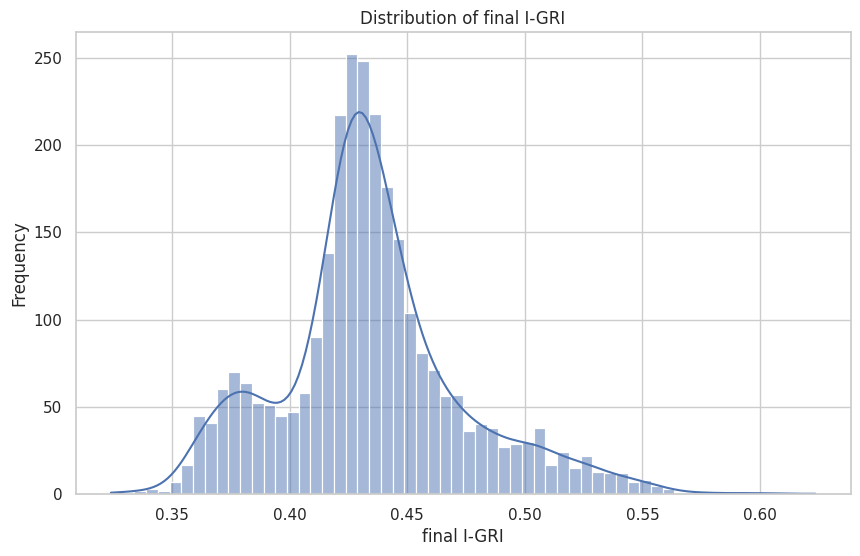

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))
sns.histplot(fundus_subset['final_I-GRI'], kde=True)

plt.title('Distribution of final I-GRI')
plt.xlabel('final I-GRI')
plt.ylabel('Frequency')

plt.show()

In [62]:
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit

glaucomaCount = len(fundus_subset[fundus_subset['types'] == '1'])
healthyCount = len(fundus_subset[fundus_subset['types'] == '0'])

print("this is the glaucoma count", glaucomaCount)
print("this is the healthy eyes count", healthyCount)

test_percentage = 0.10
val_percentage_from_train = 0.05

class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(fundus_subset['types']),
                y=fundus_subset['types'].values)

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

random_state = 1

stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=test_percentage, random_state=random_state)

for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
    train_set_temp = fundus_subset.iloc[train_index]
    test = fundus_subset.iloc[test_index]

stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=val_percentage_from_train, random_state=random_state)

for train_index, val_index in stratified_split_val.split(train_set_temp, train_set_temp['types']):
    train = train_set_temp.iloc[train_index]
    val = train_set_temp.iloc[val_index]

print("\nTotal fundus images to be used:", len(fundus_subset))
print("\nTrain set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

print("\nClass weights for model training:")
print(class_weights_dict)

train_features = train.drop('types', axis=1)
train_labels = train['types']
val_features = val.drop('types', axis=1)
val_labels = val['types']
test_features = test.drop('types', axis=1)
test_labels = test['types']

this is the glaucoma count 665
this is the healthy eyes count 2140

Total fundus images to be used: 2805

Train set size: 2397
Validation set size: 127
Test set size: 281

Class weights for model training:
{0: 0.655373831775701, 1: 2.1090225563909772}


In [63]:
print("Train Size: ", len(train))
print("Test Size: ", len(test))

Train Size:  2397
Test Size:  281


In [64]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [65]:
train

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined,OC size,OD size,NNI,I-GRI,final_I-GRI
303,1,/full-fundus/ORIGA-304.png,/optic-cup/ORIGA-304.png,/optic-disc/ORIGA-304.png,ORIGA-304,1.0,0.71875,1.0,0.232360,0.236364,0.000000,0.112603,0.569522,0.668047,ORIGA-304.png,0.161499,0.194932,0.0,0.465698,0.372558
541,0,/full-fundus/ORIGA-542.png,/optic-cup/ORIGA-542.png,/optic-disc/ORIGA-542.png,ORIGA-542,1.0,0.609375,0.0,0.093259,0.953212,0.558597,0.598061,0.544332,0.519706,ORIGA-542.png,0.104949,0.118515,0.0,0.505555,0.404444
1775,0,/full-fundus/G1020-237.png,/optic-cup/G1020-237.png,/optic-disc/G1020-237.png,G1020-237,1.0,0.296875,1.0,0.968571,0.786182,0.470515,0.331096,0.228327,0.766725,G1020-237.png,0.064103,0.250982,0.0,0.541647,0.433318
506,1,/full-fundus/ORIGA-507.png,/optic-cup/ORIGA-507.png,/optic-disc/ORIGA-507.png,ORIGA-507,1.0,0.921875,0.0,0.121241,0.798545,0.950983,0.785981,0.815064,0.275007,ORIGA-507.png,0.216557,0.155160,0.0,0.599871,0.479897
39,0,/full-fundus/ORIGA-40.png,/optic-cup/ORIGA-40.png,/optic-disc/ORIGA-40.png,ORIGA-40,1.0,0.71875,1.0,0.314581,0.869333,0.744713,0.712155,0.599451,0.343436,ORIGA-40.png,0.093421,0.099270,0.0,0.581042,0.464834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,0,/full-fundus/REFUGE1-val-398.png,/optic-cup/REFUGE1-val-398.png,/optic-disc/REFUGE1-val-398.png,REFUGE1-val-398,1.0,0.296875,1.0,0.968571,0.786182,0.470515,0.331096,0.228327,0.766725,REFUGE1-val-398.png,0.276983,0.420175,0.0,0.598521,0.478817
308,0,/full-fundus/ORIGA-309.png,/optic-cup/ORIGA-309.png,/optic-disc/ORIGA-309.png,ORIGA-309,1.0,0.40625,0.0,0.072283,0.883879,0.531227,0.419836,0.512408,0.639442,ORIGA-309.png,0.106937,0.109294,0.0,0.46189,0.369512
113,0,/full-fundus/ORIGA-114.png,/optic-cup/ORIGA-114.png,/optic-disc/ORIGA-114.png,ORIGA-114,1.0,0.40625,1.0,0.968571,0.786182,0.470515,0.331096,0.396808,0.766725,ORIGA-114.png,0.117770,0.205838,0.0,0.578147,0.462518
2538,0,/full-fundus/PAPILA-186.png,/optic-cup/PAPILA-186.png,/optic-disc/PAPILA-186.png,PAPILA-186,1.0,0.828125,0.0,0.296648,0.892121,0.802438,0.850112,0.631563,0.256711,PAPILA-186.png,0.016498,0.492583,0.0,0.609917,0.487933


In [66]:
val

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined,OC size,OD size,NNI,I-GRI,final_I-GRI
2143,0,/full-fundus/G1020-714.png,/optic-cup/G1020-714.png,/optic-disc/G1020-714.png,G1020-714,1.0,0.296875,1.0,0.968571,0.786182,0.470515,0.331096,0.228327,0.766725,G1020-714.png,0.050189,0.384171,0.0,0.56101,0.448808
1988,0,/full-fundus/G1020-502.png,/optic-cup/G1020-502.png,/optic-disc/G1020-502.png,G1020-502,1.0,0.296875,1.0,0.968571,0.786182,0.470515,0.331096,0.228327,0.766725,G1020-502.png,0.050487,0.117072,0.0,0.518315,0.414652
633,1,/full-fundus/ORIGA-634.png,/optic-cup/ORIGA-634.png,/optic-disc/ORIGA-634.png,ORIGA-634,1.0,0.359375,1.0,0.937399,0.674424,0.430704,0.266219,0.439830,0.799618,ORIGA-634.png,0.107434,0.218667,0.0,0.562296,0.449837
2599,1,/full-fundus/PAPILA-254.png,/optic-cup/PAPILA-254.png,/optic-disc/PAPILA-254.png,PAPILA-254,1.0,0.53125,1.0,0.409344,0.626182,0.429211,0.229679,0.518678,0.700088,PAPILA-254.png,0.326873,0.418170,0.0,0.587364,0.469891
1260,0,/full-fundus/REFUGE1-val-66.png,/optic-cup/REFUGE1-val-66.png,/optic-disc/REFUGE1-val-66.png,REFUGE1-val-66,1.0,0.296875,1.0,0.968571,0.786182,0.470515,0.331096,0.228327,0.766725,REFUGE1-val-66.png,0.113198,0.227889,0.0,0.544826,0.435861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,0,/full-fundus/DRISHTI-GS1-train-3.png,/optic-cup/DRISHTI-GS1-train-3.png,/optic-disc/DRISHTI-GS1-train-3.png,DRISHTI-GS1-train-3,1.0,0.6875,1.0,0.275414,0.799758,0.594924,0.633110,0.583121,0.440529,DRISHTI-GS1-train-3.png,0.330650,0.386256,0.0,0.641116,0.512893
2022,0,/full-fundus/G1020-547.png,/optic-cup/G1020-547.png,/optic-disc/G1020-547.png,G1020-547,1.0,0.296875,1.0,0.968571,0.786182,0.470515,0.331096,0.228327,0.766725,G1020-547.png,0.223117,0.343116,0.0,0.578651,0.462921
908,0,/full-fundus/REFUGE1-train-259.png,/optic-cup/REFUGE1-train-259.png,/optic-disc/REFUGE1-train-259.png,REFUGE1-train-259,1.0,0.296875,1.0,0.968571,0.786182,0.470515,0.331096,0.228327,0.766725,REFUGE1-train-259.png,0.103061,0.120359,0.0,0.526202,0.420962
1058,1,/full-fundus/CRFO-v4-10.png,/optic-cup/CRFO-v4-10.png,/optic-disc/CRFO-v4-10.png,CRFO-v4-10,1.0,0.5625,1.0,0.024388,0.192000,0.328440,0.292319,0.600965,0.656153,CRFO-v4-10.png,0.242894,0.137840,0.0,0.478458,0.382766


In [67]:
test

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,combined,OC size,OD size,NNI,I-GRI,final_I-GRI
2750,1,/full-fundus/PAPILA-432.png,/optic-cup/PAPILA-432.png,/optic-disc/PAPILA-432.png,PAPILA-432,1.0,0.6875,1.0,0.160665,0.491152,0.337149,0.325876,0.576200,0.648722,PAPILA-432.png,0.135957,0.596584,0.0,0.58486,0.467888
1427,0,/full-fundus/REFUGE1-val-233.png,/optic-cup/REFUGE1-val-233.png,/optic-disc/REFUGE1-val-233.png,REFUGE1-val-233,1.0,0.296875,1.0,0.968571,0.786182,0.470515,0.331096,0.228327,0.766725,REFUGE1-val-233.png,0.127211,0.294203,0.0,0.557398,0.445918
2142,0,/full-fundus/G1020-713.png,/optic-cup/G1020-713.png,/optic-disc/G1020-713.png,G1020-713,1.0,0.296875,1.0,0.968571,0.786182,0.470515,0.331096,0.228327,0.766725,G1020-713.png,0.081097,0.218106,0.0,0.538766,0.431013
1075,0,/full-fundus/CRFO-v4-50.png,/optic-cup/CRFO-v4-50.png,/optic-disc/CRFO-v4-50.png,CRFO-v4-50,1.0,0.46875,0.0,0.161105,0.861333,0.528738,0.396719,0.488454,0.641410,CRFO-v4-50.png,0.144902,0.223238,0.0,0.490099,0.392079
20,0,/full-fundus/ORIGA-21.png,/optic-cup/ORIGA-21.png,/optic-disc/ORIGA-21.png,ORIGA-21,1.0,0.484375,1.0,0.076537,0.859879,0.535457,0.390007,0.500187,0.646285,ORIGA-21.png,0.186047,0.243605,0.0,0.545619,0.436495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,0,/full-fundus/REFUGE1-train-255.png,/optic-cup/REFUGE1-train-255.png,/optic-disc/REFUGE1-train-255.png,REFUGE1-train-255,1.0,0.296875,1.0,0.968571,0.786182,0.470515,0.331096,0.228327,0.766725,REFUGE1-train-255.png,0.147784,0.254992,0.0,0.554004,0.443203
1214,0,/full-fundus/REFUGE1-val-20.png,/optic-cup/REFUGE1-val-20.png,/optic-disc/REFUGE1-val-20.png,REFUGE1-val-20,1.0,0.296875,1.0,0.968571,0.786182,0.470515,0.331096,0.228327,0.766725,REFUGE1-val-20.png,0.086166,0.202710,0.0,0.537013,0.42961
208,0,/full-fundus/ORIGA-209.png,/optic-cup/ORIGA-209.png,/optic-disc/ORIGA-209.png,ORIGA-209,1.0,0.421875,1.0,0.968571,0.786182,0.470515,0.331096,0.414391,0.766725,ORIGA-209.png,0.120254,0.166627,0.0,0.576421,0.461137
2460,0,/full-fundus/PAPILA-105.png,/optic-cup/PAPILA-105.png,/optic-disc/PAPILA-105.png,PAPILA-105,1.0,0.59375,0.0,0.084018,0.834909,0.528987,0.470544,0.551388,0.567636,PAPILA-105.png,0.007454,0.416085,0.0,0.515391,0.412313


In [68]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import Rescaling
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 


target = 224
batchSize = 1

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen1 = trainDataGen1.flow_from_dataframe(dataframe=train, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen1 = valDataGen1.flow_from_dataframe(dataframe=val,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen1 = testDataGen1.flow_from_dataframe(dataframe=test,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 2397 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.
Found 281 validated image filenames belonging to 2 classes.


In [69]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

target = 224
batchSize = 1

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen2 = trainDataGen2.flow_from_dataframe(dataframe=train, 
                                                directory='optic-cup/optic-cup', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen2 = valDataGen2.flow_from_dataframe(dataframe=val,
                                            directory='optic-cup/optic-cup',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen2 = testDataGen2.flow_from_dataframe(dataframe=test,
                                            directory='optic-cup/optic-cup',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 2397 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.
Found 281 validated image filenames belonging to 2 classes.


In [70]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

target = 224
batchSize = 1

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen3 = trainDataGen3.flow_from_dataframe(dataframe=train, 
                                                directory='optic-disc/optic-disc', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen3 = valDataGen3.flow_from_dataframe(dataframe=val,
                                            directory='optic-disc/optic-disc',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen3 = testDataGen3.flow_from_dataframe(dataframe=test,
                                                directory='optic-disc/optic-disc', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=False, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')

Found 2397 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.
Found 281 validated image filenames belonging to 2 classes.


In [71]:
def combined_generator(generators, num_features, labels, batch_size):
    while True:

        images_batch = [next(gen)[0] for gen in generators]
        
        idx = (generators[0].batch_index - 1) * generators[0].batch_size
        batch_index = np.arange(idx, min(idx + batch_size, len(num_features)))
        
        num_features_batch = np.array(num_features[batch_index], dtype=np.float32)
        
        labels_batch = np.array(labels[batch_index], dtype=np.float32)

        yield images_batch + [num_features_batch], labels_batch

num_features = train[['age', 'gender', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size', 'final_I-GRI']].astype(np.float32).values
labels = train['types'].values.astype(np.float32)

train_generator = combined_generator(
    [trainGen1, trainGen2, trainGen3],
    num_features,
    labels,
    batchSize
)

val_features = val[['age', 'gender', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size', 'final_I-GRI']].astype(np.float32).values
val_labels = val['types'].values.astype(np.float32)

val_generator = combined_generator(
    [valGen1, valGen2, valGen3],
    val_features,
    val_labels,
    batchSize
)

test_features = test[['age', 'gender', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size', 'final_I-GRI']].astype(np.float32).values
test_labels = test['types'].values.astype(np.float32)

test_generator = combined_generator(
    [testGen1, testGen2, testGen3],
    test_features,
    test_labels,
    batchSize
)


In [72]:
mock_batch_data, mock_batch_labels = next(train_generator)

print("Image batch shape:", mock_batch_data[0].shape)
print("Image batch shape:", mock_batch_data[1].shape)
print("Image batch shape:", mock_batch_data[2].shape)
print("Numerical batch shape:", mock_batch_data[3].shape)
print("Label batch shape:", mock_batch_labels.shape)

Image batch shape: (1, 224, 224, 3)
Image batch shape: (1, 224, 224, 3)
Image batch shape: (1, 224, 224, 3)
Numerical batch shape: (1, 12)
Label batch shape: (1,)


In [84]:
mock_batch_data, mock_batch_labels = next(test_generator)

print("Image batch shape:", mock_batch_data[0].shape)
print("Image batch shape:", mock_batch_data[1].shape)
print("Image batch shape:", mock_batch_data[2].shape)
print("Numerical batch shape:", mock_batch_data[3].shape)
print("Label batch shape:", mock_batch_labels.shape)

Image batch shape: (1, 224, 224, 3)
Image batch shape: (1, 224, 224, 3)
Image batch shape: (1, 224, 224, 3)
Numerical batch shape: (1, 12)
Label batch shape: (1,)


In [91]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate

image_input_shape = (224, 224, 3)
num_features = 12

fundus_input = Input(shape=image_input_shape, name='fundus_input')
optic_cup_input = Input(shape=image_input_shape, name='optic_cup_input')
optic_disc_input = Input(shape=image_input_shape, name='optic_disc_input')

num_features_input = Input(shape=(num_features,), name='numerical_input')

def simple_cnn(input_img):
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return x

fundus_features = simple_cnn(fundus_input)
optic_cup_features = simple_cnn(optic_cup_input)
optic_disc_features = simple_cnn(optic_disc_input)

combined_features = concatenate([fundus_features, optic_cup_features, optic_disc_features, num_features_input])

x = Dense(256, activation='relu')(combined_features)
x = Dense(128, activation='relu')(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[fundus_input, optic_cup_input, optic_disc_input, num_features_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 fundus_input (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 optic_cup_input (InputLaye  [(None, 224, 224, 3)]        0         []                            
 r)                                                                                               
                                                                                                  
 optic_disc_input (InputLay  [(None, 224, 224, 3)]        0         []                            
 er)                                                                                              
                                                                                            

: 

In [86]:
history = model.fit(
    
    x=train_generator,
    epochs=10,
    steps_per_epoch=len(trainGen1),
    validation_data=val_generator,
    validation_steps=len(valGen1),
    class_weight=class_weights_dict
)

Epoch 1/10


2397/2397 [==============================] - 65s 25ms/step - loss: 2.3781 - accuracy: 0.7526 - val_loss: 0.1918 - val_accuracy: 0.9449
Epoch 2/10
2397/2397 [==============================] - 64s 27ms/step - loss: 0.1832 - accuracy: 0.9516 - val_loss: 0.1073 - val_accuracy: 0.9685
Epoch 3/10
2397/2397 [==============================] - 69s 29ms/step - loss: 0.0857 - accuracy: 0.9779 - val_loss: 0.0857 - val_accuracy: 0.9843
Epoch 4/10
2397/2397 [==============================] - 65s 27ms/step - loss: 0.0556 - accuracy: 0.9862 - val_loss: 0.0771 - val_accuracy: 0.9843
Epoch 5/10
2397/2397 [==============================] - 65s 27ms/step - loss: 0.0458 - accuracy: 0.9866 - val_loss: 0.0701 - val_accuracy: 0.9843
Epoch 6/10
2397/2397 [==============================] - 68s 28ms/step - loss: 0.1899 - accuracy: 0.9729 - val_loss: 0.0584 - val_accuracy: 0.9843
Epoch 7/10
2397/2397 [==============================] - 64s 27ms/step - loss: 0.0420 - accuracy: 0.9896 - val_loss: 0.0583 - val_accura

In [87]:
batchSize = 1 

def generate_evaluation_batches(image_gens, num_features, batch_size):

    while True:

        batches = [gen.next() for gen in image_gens]
        image_batches = [batch[0].astype(np.float32) for batch in batches]
        
        idx = (image_gens[0].batch_index - 1) * batch_size
        batch_index = np.arange(idx, min(idx + batch_size, len(num_features)))

        yield image_batches + [num_features[batch_index]], batches[0][1]


val_evaluation_generator = generate_evaluation_batches([valGen1, valGen2, valGen3], val_features, 1)

test_evaluation_generator = generate_evaluation_batches([testGen1, testGen2, testGen3], test_features, 1)

val_steps = len(val) // batchSize
test_steps = len(test) // batchSize

val_loss, val_accuracy = model.evaluate(val_evaluation_generator, steps=val_steps)
print('Validation accuracy:', val_accuracy)

test_loss, test_accuracy = model.evaluate(test_evaluation_generator, steps=test_steps)
print('Test accuracy:', test_accuracy)

127/127 [==============================] - 3s 27ms/step - loss: 0.0619 - accuracy: 0.9764
Validation accuracy: 0.9763779640197754
281/281 [==============================] - 8s 28ms/step - loss: 0.0275 - accuracy: 0.9858
Test accuracy: 0.9857650995254517


In [89]:
import numpy as np
from sklearn.metrics import classification_report

predictions = model.predict(test_generator, steps=len(testGen1))
predicted_classes = (predictions > 0.5).astype(int).flatten()

actual_labels = []
for _, labels in test_evaluation_generator:
    actual_labels.extend(labels)
    if len(actual_labels) >= len(testGen1) * batchSize:
        break

actual_labels = np.array(actual_labels)[:len(predicted_classes)]

report = classification_report(actual_labels, predicted_classes)
print(report)

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(actual_labels, predicted_classes)
print(conf_matrix)

281/281 [==============================] - 6s 23ms/step
              precision    recall  f1-score   support

         0.0       0.76      0.77      0.77       214
         1.0       0.25      0.24      0.24        67

    accuracy                           0.64       281
   macro avg       0.51      0.50      0.50       281
weighted avg       0.64      0.64      0.64       281

[[165  49]
 [ 51  16]]
